# Fairness Exemplo 1

Ideia: Criar um Modelo de Predição simples a partir da base de dados "adult.csv" e checar de alguma forma se a restrição de independência está sendo cumprida para o atributo sensível RAÇA.

Independência: P{R = 1; A = a} = P{R = 1; A = b}; Para todo grupo a e b

Primeiro vou fazer um modelo simples, só inserindo tudo. Aparentemente a base já veio com tratamento de nulos, então provavelmente já foi feito um pré-processamento.
Basicamente procuro checar as 3 principais Restrições de Group Fairness para esse Dataset, e também mostrar que simplesmente excluir o Atr.Prot. não causa tanto impacto no Fairness em si.

Importando as bibliotecas principais e recebendo os dados.

In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from preProcess import preProcessamento

df = pd.read_csv(".\\adult.csv")
df, raceData, _ = preProcessamento(df, 'ordinal')
# a ideia é agrupar certos valores, idade e outros
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   age              48842 non-null  int64
 1   fnlwgt           48842 non-null  int64
 2   educational-num  48842 non-null  int64
 3   capital-gain     48842 non-null  int64
 4   capital-loss     48842 non-null  int64
 5   hours-per-week   48842 non-null  int64
 6   income           48842 non-null  int64
 7   workclass        48842 non-null  int16
 8   marital-status   48842 non-null  int16
 9   occupation       48842 non-null  int16
 10  relationship     48842 non-null  int16
 11  gender           48842 non-null  int16
dtypes: int16(5), int64(7)
memory usage: 3.1 MB


In [39]:
from sklearn.feature_selection import mutual_info_classif

mi_scores = mutual_info_classif(df.drop('income', axis = 1), df['income'], discrete_features = True)

mi_scores = pd.Series(mi_scores, name = "MI Scores", index = df.drop('income', axis = 1).columns)

mi_scores = mi_scores.sort_values(ascending = False)

mi_scores
#n sei oq interpretar
#antes de fazer isso vou agrupar certos valores (idade e talvez formação)
#utilizar o scaler para normalizar valores numericos
#utilizar log no fnlwgt

fnlwgt             0.355773
relationship       0.114663
marital-status     0.108826
capital-gain       0.082879
age                0.067911
educational-num    0.063819
occupation         0.063672
hours-per-week     0.041552
capital-loss       0.036933
gender             0.025431
workclass          0.015447
Name: MI Scores, dtype: float64

Separando os dados entre X e Y, onde Y é a variável alvo.
Após isso faço um split para termos os dados de teste e os de treino. Fixo um random_state para checar melhor os resultados.

In [40]:
from sklearn.model_selection import StratifiedKFold
# x = data.drop(['income'], axis=1)
# Y = data["income"]
data = df.copy()
data['kfold'] = -1

data = data.sample(frac = 1, random_state= 13)
kf = StratifiedKFold(n_splits = 5)
# from sklearn.model_selection import train_test_split
# x_train, x_test, y_train, y_test = train_test_split(x, Y, test_size = 0.3, random_state = 1)

for fold,(train_indexes, test_indexes) in enumerate(kf.split(df, df['income'].values)):
    data.loc[test_indexes, 'kfold'] = np.int16(fold)
data.head()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,income,workclass,marital-status,occupation,relationship,gender,kfold
19287,37,267086,11,0,0,52,0,4,0,13,4,0,1
16606,63,78383,9,0,0,45,0,6,2,5,0,1,1
16979,30,189620,13,0,0,40,0,4,4,10,3,0,1
24846,19,217769,10,594,0,10,0,0,4,0,3,0,2
26074,45,94754,14,0,0,40,0,7,2,1,0,1,2


Descrever melhor depois.

# Classificador (Árvore de Decisão) 
Após isso, faço o modelo propriamente dito, utilizo um Classificador de Árvore de decisão e efetuo a predição, fixo um random_state para ter o mesmo MAE, mas o valor do MAE é cerca de 0.18, variando um pouco pra mais ou pra menos.

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_absolute_error

#utilizar outro modelo depois

recalls = []
fscores = []
mae = []

for i in range(5):
    train_df = data[data['kfold']!=i]
    test_df  = data[data['kfold']==i]

    x_train = train_df.drop(['income', 'kfold'], axis = 1)
    y_train = train_df.income

    x_test = test_df.drop(['income', 'kfold'], axis = 1)
    y_test = test_df.income

    modelo = DecisionTreeClassifier()

    modelo.fit(x_train, y_train)
    previsao = modelo.predict(x_test)
    
    mae.append(mean_absolute_error(y_test, previsao))
    recalls.append(recall_score(y_test, previsao))
    fscores.append(f1_score(y_test, previsao))

acuracia = sum(mae)/5
print(acuracia)

acuracia = sum(recalls)/5
print(acuracia)

acuracia = sum(fscores)/5
print(acuracia)

0.18539368335662737
0.6230876226640796
0.6165866034541729


Aqui vem a parte final. Checar a independência, como não sei uma forma de quantificar tudo isso resolvi fazer essa checagem por meio de gráficos. Um gráfico que mostra a proporção de pessoas que são classificadas, como positivas ou negativas, separadas por raça.

Primeiro eu inverto a transformação feita antes nas variáveis categóricas, após isso eu junto o X-Teste com a Previsão com os valores de Ŷ, que são os Y's do Classificador.
Após isso eu seleciono apenas os Atributos Raça e o Ŷ. Depois eu agrupo os dados a partir do Ŷ e conto os valores separados por raça.
Com isso, eu conto os valores apenas por Raça, para saber quantas pessoas eu tenho de cada Raça. Então eu faça uma Junção para ter um registro formado por:

Ŷ - Raça - Quantidade de Ŷ para aquela raça - Quantidade de Pessoas daquela raça.

OBS: Não sei se fazer essa junção era a maneira mais fácil de fazer o que eu fiz, mas foi a única que lembrei como fazer, talvez encontre uma forma melhor e mais rápida depois.

Para finalizar eu reverto a codificação binária que fiz no Y, e obtenho a Proporção de Ŷ para aquela raça a partir de:

(Quantidade de Ŷ para aquela raça) / (Quantidade de Pessoas daquela raça).

In [42]:
df = x_test.copy()
df['race'] = raceData 

df["previsao"] = previsao
df = df[["race", "previsao"]]
hue = "previsao"
dfe = pd.DataFrame(df.groupby('previsao').value_counts().rename("count").reset_index())

dfd = df["race"].value_counts()
dfd = dfd.reset_index()
dfe = dfe.merge(dfd, left_on='race', right_on='index')
dfe = dfe.drop("index", axis = 1)

dfe = dfe.rename(columns = {"race_x": "race", "race_y": "total"})
dfe["proportion"] = dfe["count"]/dfe["total"]*100

dfe['previsao'] = dfe["previsao"].apply(lambda p: '>50K' if p == 1 else '<=50K')
print(dfe)

  previsao          race  count  total  proportion
0    <=50K    Privileged   6127   8317   73.668390
1     >50K    Privileged   2190   8317   26.331610
2    <=50K  Unprivileged   1192   1451   82.150241
3     >50K  Unprivileged    259   1451   17.849759


# Classificador (Árvore de Decisão) Protegido
A Partir daqui repito os passos para o Modelo Protegido

### Restrição de "Statistical Parity"
Checagem da Restrição de Paridade Estatística para esse Modelo.

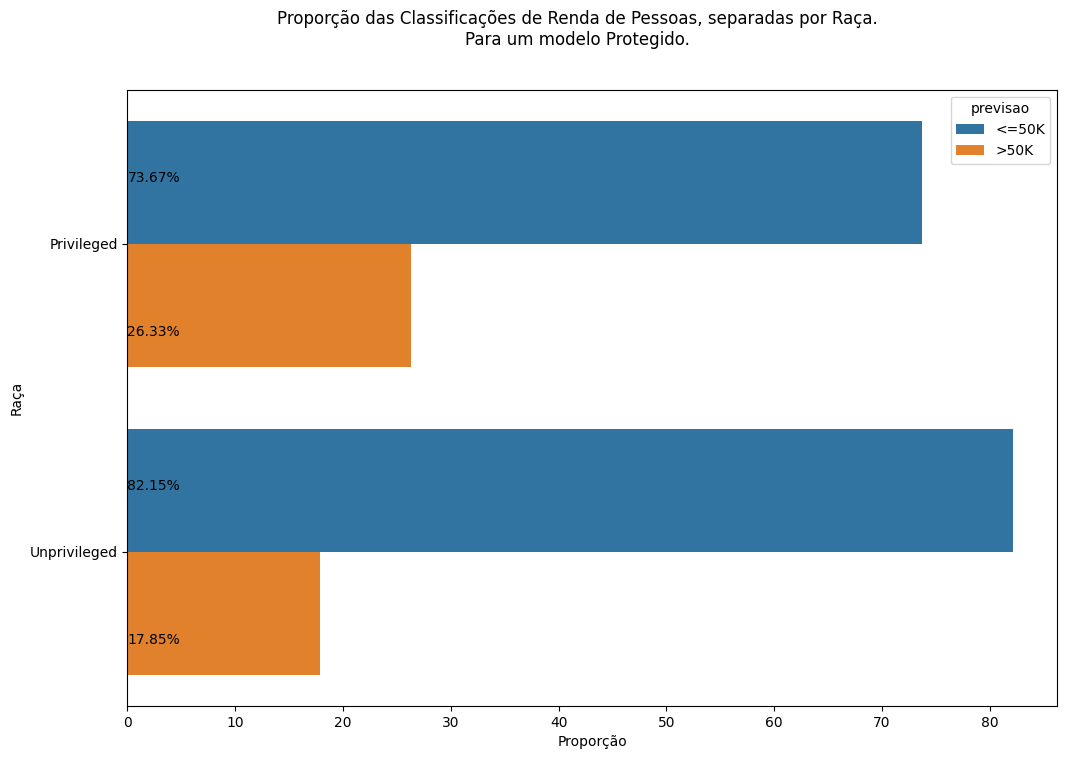

In [43]:
fig = plt.figure(figsize = (12, 8))
fig.suptitle("Proporção das Classificações de Renda de Pessoas, separadas por Raça.\nPara um modelo Protegido.")

plot = sns.barplot(data = dfe, x = "proportion", y = "race", hue = "previsao")
plot.set_ylabel("Raça")
plot.set_xlabel("Proporção")

for index, row in dfe.iterrows():
    plot.text(0, (row.name)/2 - 0.2, str(round(row.proportion, 2)) + "%",color='black')
    
# plot1 = sns.barplot(ax = ax[1], data = dfeProtected,x = "proportion", y = "race", hue = "previsao")
plot.set_ylabel("Raça")
plot.set_xlabel("Proporção")
plt.show()
fig.savefig("output1.png")

### Restrição de "Equalized Odds"

In [44]:
newdata = pd.DataFrame()
indexes = x_test.index
newdata['race'] = (raceData.loc[indexes]).copy()
newdata['previsao'] = previsao.copy()
newdata['income'] = y_test.copy()

In [45]:
races = newdata['race'].unique()
tabela = pd.DataFrame(columns = ['Race', 'Valor', 'Tipo'])

for race in races:
    groupedRaces = (newdata.loc[(newdata['race'] == race)])
    crosstab = pd.crosstab(groupedRaces['previsao'], groupedRaces['income'], margins = True)

    valor = crosstab.iloc[0,0]/crosstab.iloc[2,0]
    valor2 = crosstab.iloc[1,1]/crosstab.iloc[2,1]

    tabela.loc[-1] = [race, valor, 'Rejeitado']
    tabela.index = tabela.index + 1
    tabela = tabela.sort_index()
    tabela.loc[-1] = [race, valor2, 'Aceitado']
    tabela.index = tabela.index + 1
    tabela = tabela.sort_index()

tabela['Valor'] = tabela['Valor'] * 100

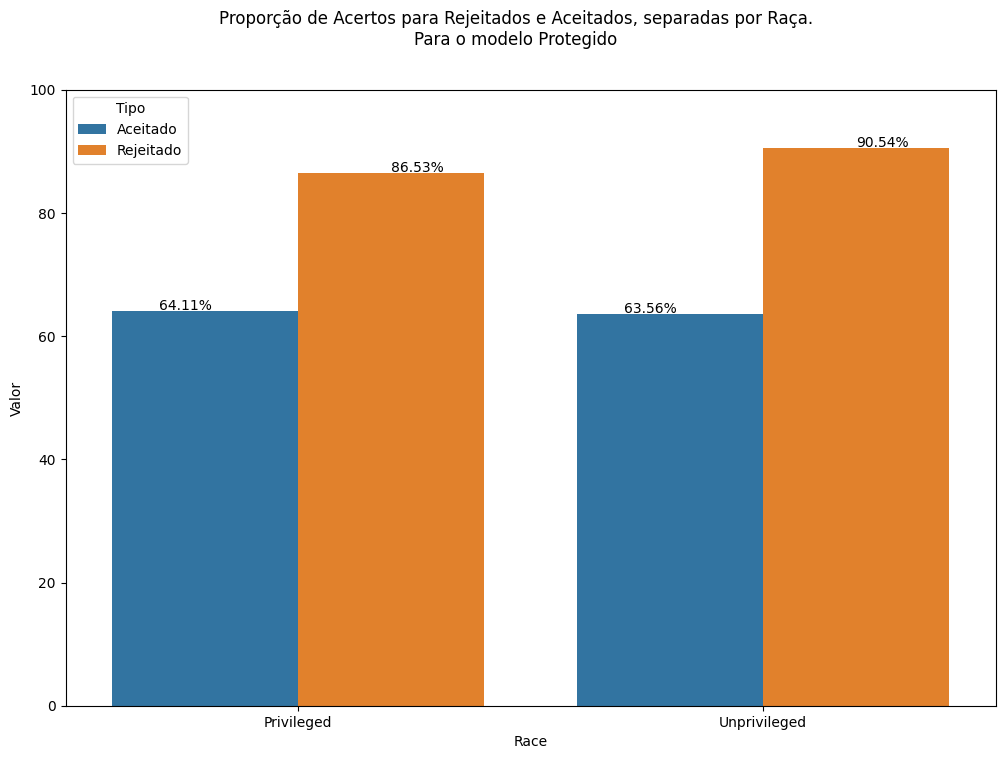

In [46]:
fig2 = plt.figure(figsize = (12, 8))
fig2.suptitle("Proporção de Acertos para Rejeitados e Aceitados, separadas por Raça.\nPara o modelo Protegido")

# plot = sns.barplot(ax2 = ax2[0], data = ,x = "proportion", y = "race", hue = "income")
plot.set_ylabel("Raça")
plot.set_xlabel("Proporção")    

plot2 = sns.barplot(data = tabela, x = "Race", y = "Valor", hue = "Tipo")

for index, row in tabela.iterrows():
    plot2.text((row.name)/2 - 0.3, (row.Valor) + 0.2, str(round(row.Valor, 2)) + "%",color='black')

plt.ylim((0,100))
plt.show()
fig2.savefig("output2.png")

### Restrição de "Predictive Parity"

In [47]:
newdata = pd.DataFrame()
indexes = x_test.index
newdata['race'] = (raceData.loc[indexes]).copy()
newdata['previsao'] = previsao.copy()
newdata['income'] = y_test.copy()

In [48]:
races = newdata['race'].unique()
tabela1 = pd.DataFrame(columns = ['Race', 'Valor'])

for race in races:
    groupedRaces = (newdata.loc[(newdata['race'] == race)])

    valor = mean_absolute_error(groupedRaces['income'], groupedRaces['previsao'])

    tabela1.loc[-1] = [race, valor]
    tabela1.index = tabela1.index + 1
    tabela1 = tabela1.sort_index()

tabela1['Valor'] = - (tabela1['Valor'] * 100) + 100 

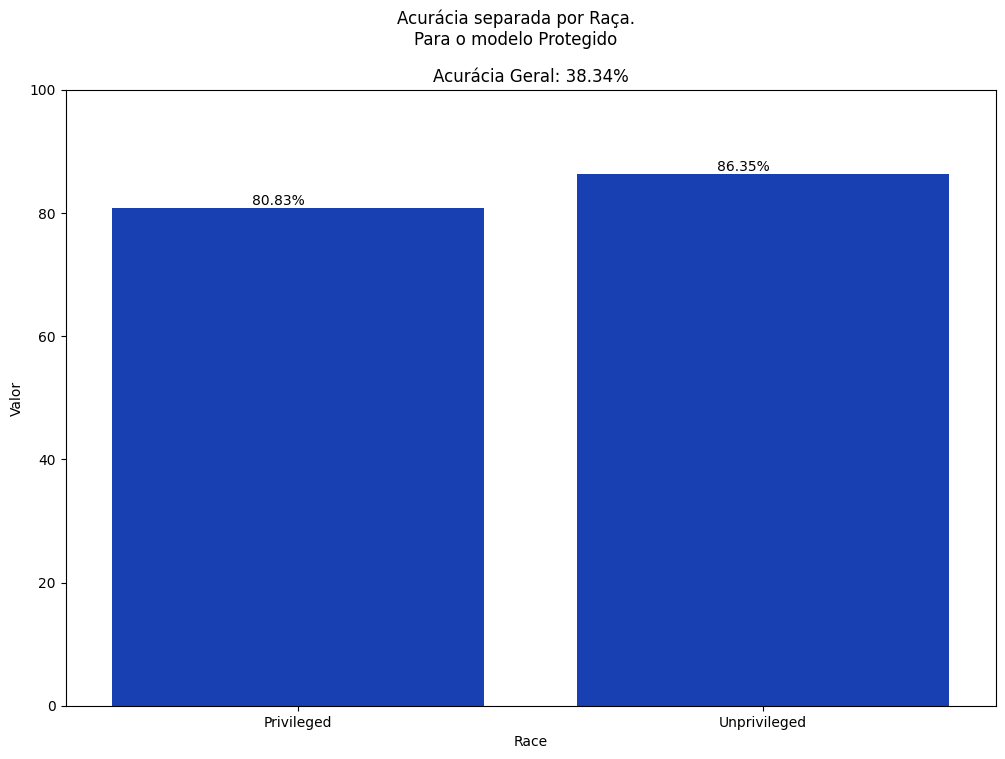

In [49]:
fig3 = plt.figure(figsize = (12, 8))
fig3.suptitle("Acurácia separada por Raça.\nPara o modelo Protegido")

# plot = sns.barplot(ax2 = ax2[0], data = ,x = "proportion", y = "race", hue = "income")
# plot.set_ylabel("Raça")
# plot.set_xlabel("Proporção")    

plot2 = sns.barplot(data = tabela1, x = "Race", y = "Valor", color = "#0033cc")

for index, row in tabela1.iterrows():
    plot2.text((row.name) - 0.10, (row.Valor) + 0.5, str(round(row.Valor, 2)) + "%",color='black')


plt.title("Acurácia Geral: " + str(round(-(acuracia * 100) + 100, 2)) + "%")
plt.ylim((0,100))
plt.show()
fig3.savefig("output3.png")

## Conclusão:
Os valores das Proporções, que nesse caso podem ser interpretados como Probabilidades, diferem bastante entre si, tanto no modelo protegido, quanto no não protegido, assim a restrição de Independência, ou Paridade Estatística, não estão sendo atendidas por esses Modelos.

OBS: Mantive as 5 raças para ter uma primeira ideia inicial melhor, na prática era melhor transformá-los em Favorecidos e Desfavorecidos, fica mais fácil na prática. Também não fiz os gráficos das outras restrições para o Modelo não protegido por quê provalvemente seriam resultados bem próximos. Esse foi o primeiro mini-projeto que fiz com Fairness então ele provavelmente tem diversos erros.